In [1]:
import numpy as np
import math
import imageio
import gzip
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def cal_accuracy(predict, actual):
    count = 0
    Loss_fnc = []
    for i in range(len(predict)):
        if predict[i] == actual[i]:
            count += 1
            Loss_fnc.append(0)
        else:
            Loss_fnc.append(1)
     
    accuracy = ( 1 - sum(Loss_fnc)/len(predict) ) * 100
    
    return accuracy
t_initial = time.time()

##############################################################################
############ PART 1 - MEAN AND STANDARD DEVIATION OF THE FEATURES ############
##############################################################################


Reading the training data.


Calculating mean and standard deviation digits. 

 Mean and standard deviation digits calculated.


 -------------------------------------------------------------------------------------

Displaying the mean and standard deviation digits side-by-side.

----------------------------------------------------------------------------------------


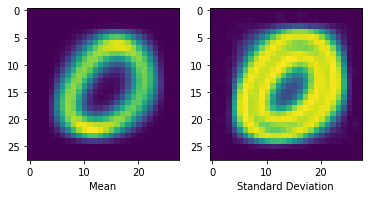

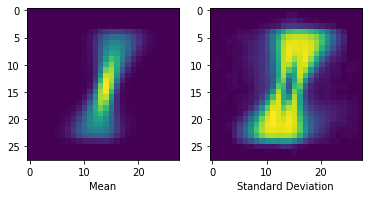

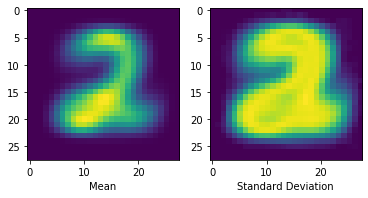

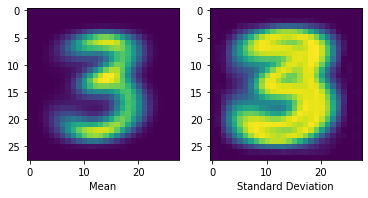

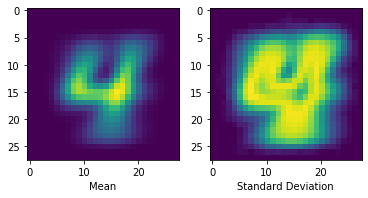

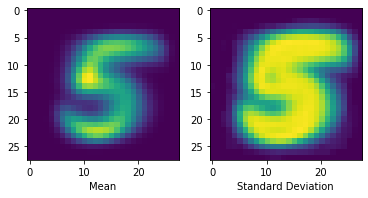

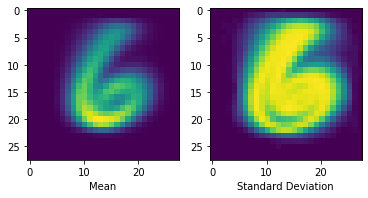

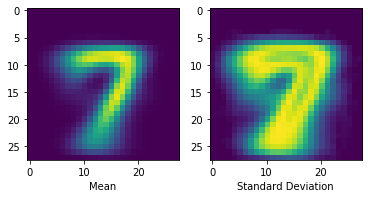

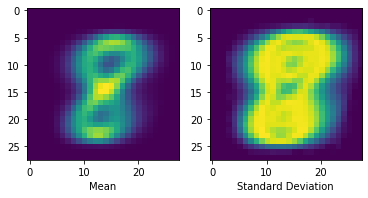

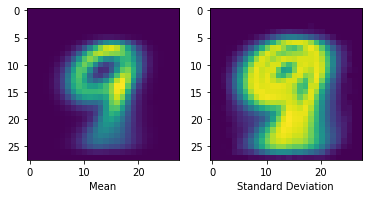

In [3]:
print("##############################################################################")
print("############ PART 1 - MEAN AND STANDARD DEVIATION OF THE FEATURES ############")
print("##############################################################################") 

print("\n\nReading the training data.") 

f_train = gzip.open('train-images-idx3-ubyte.gz', 'r')
f_train.read(16)
img_dimen = 28
flatten_size = img_dimen*img_dimen

n_img = 60000
buf = f_train.read(img_dimen * img_dimen * n_img)

data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(n_img, img_dimen * img_dimen)

# Extract the MNIST label values
f_labels = gzip.open('train-labels-idx1-ubyte.gz','r')

f_labels.read(8)
buf_labels = f_labels.read(1 * 60000)
labels = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

mean_digits = np.zeros((10, flatten_size))
count = np.zeros((10,1))
std_digits = np.zeros((10, flatten_size))

X = {
     '0':[],
     '1':[],
     '2':[],
     '3':[],
     '4':[],
     '5':[],
     '6':[],
     '7':[],
     '8':[],
     '9':[]
     }

# Calculate mean digits
print ("\n\nCalculating mean and standard deviation digits. ")
for index, item in enumerate(labels):
    for i in range(10):
        if item == i:
            X[str(i)].append(data[index])
            mean_digits[item] += data[index]
            count[item]+=1

# Generate mean digits
for i in range(mean_digits.shape[0]):
    mean_digits[i] = mean_digits[i] / count[i]

# Calculate standard deviation digits
for i in range(10):
    for item in X[str(i)]:
        std_digits[i] += (item - mean_digits[i])**2

# Generate STD digits
for i in range(std_digits.shape[0]):
    std_digits[i] = np.sqrt(std_digits[i] / count[i])
    
print("\n Mean and standard deviation digits calculated.")

print("\n\n -------------------------------------------------------------------------------------")
print ("\nDisplaying the mean and standard deviation digits side-by-side.")
print ("\n----------------------------------------------------------------------------------------")

## Display mean digits
for i in range(10):
    mean_show = mean_digits[i].reshape(28,28,1).squeeze()
    std_show = np.asarray(std_digits[i]).reshape(28,28,1).squeeze()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(mean_show)
    plt.xlabel("Mean")
    imageio.imwrite('mean_img' + str(i) + '.png', np.asarray(mean_show, dtype = np.uint8))
    plt.subplot(1,2,2)
    plt.imshow(std_show)
    plt.xlabel("Standard Deviation")
    imageio.imwrite('std_img' + str(i) + '.png', np.asarray(std_show, dtype = np.uint8))
    plt.show()


In [4]:
print("##############################################################################")
print("############ PART 2 - CLASSIFICATION AND 0/1 LOSS FUNCTION ###################")
print("##############################################################################")  

prior = np.zeros((10,1))
prior = count/60000
        
cov_determinant = []
cov_inverse = []

covariance_digits = np.zeros((10, flatten_size, flatten_size))
covariance_naive = np.zeros((10,flatten_size,flatten_size))
cov_determinant = np.zeros((count.shape[0], 1))
cov_inverse = np.zeros((len(count), flatten_size, flatten_size))

naive_determinant = np.zeros((count.shape[0], 1))
naive_inverse = np.zeros((len(count), flatten_size, flatten_size))


print ("\n\nCalculating Covariance Matrices, its Determinant and its Inverse. ")
# Calculate normal covariance matrix
for i in range(10):
    for image in X[str(i)]:
        temp_calc = image - mean_digits[i]
        t = np.transpose(temp_calc)
        covariance_digits[i] = covariance_digits[i] + np.dot(t, temp_calc)


# Calculate naive covairance matrix
for i in range(10):
    covariance_naive[i] += std_digits[i] * np.eye(flatten_size) 

# Compute the determinant and inverse of the matrices
for i in range(count.shape[0]):
    covariance_digits[i] = np.divide( covariance_digits[i], (count[i] - 1) ) + 0.9*np.eye(784)
    sign, determinant = np.linalg.slogdet(covariance_digits[i])
    act_det = sign*np.exp(determinant)

    cov_determinant[i] = act_det
    
    inverse = np.linalg.inv(covariance_digits[i])
    cov_inverse[i] = inverse
    
    covariance_naive[i] += 0.9*np.eye(flatten_size)
    n_sign, n_determinant = np.linalg.slogdet(covariance_naive[i])
    n_act_det = n_sign * np.exp(n_determinant)
    naive_determinant[i] = n_act_det
    
    n_inverse = np.linalg.inv(covariance_naive[i])
    naive_inverse[i] = n_inverse

print("\nCovariance Matrix, Determinant and Inverse calculated.")
    
# Read the testing data  

print("\n\nReading the testing data.")  
f_test = gzip.open('t10k-images-idx3-ubyte.gz', 'r')
f_test.read(16)
n_img_test = 10000
buf_test = f_test.read(img_dimen * img_dimen * n_img_test)

data_test = np.frombuffer(buf_test, dtype=np.uint8).astype(np.float32)
data_test = data_test.reshape(n_img_test, img_dimen * img_dimen)

# Extract the MNIST Test label values

f_test_labels = gzip.open('t10k-labels-idx1-ubyte.gz','r')

f_test_labels.read(8)
buf_test_labels = f_test_labels.read(1 * 10000)
test_labels = np.frombuffer(buf_test_labels, dtype=np.uint8).astype(np.int64)

D = flatten_size

test_predict = []
naive_test_predict = []

print("\n\nPerforming classification using Bayes Decision Rule and reporting performance.")
for index in range(len(test_labels)):
    likelihood = []
    likelihood_naive = []
    
    
    for i in range(10):
        
        # Reshape the test_image to 1xflatten_size after raveling, as dimension of data_test[index].ravel() = flatten_sizex1, resulting in a matrix
        temp = data_test[index] - mean_digits[i]
        # Using np.dot is imperative for dot product, because normal multiplication does element wise multiplication
        # and not matrix multiplication
        temp_calc = np.dot(np.dot(temp, cov_inverse[i]), np.transpose(temp))
        n_temp_calc = np.dot(np.dot(temp, naive_inverse[i]), np.transpose(temp))
        
        log_likelihood = - ( D*0.5 )*np.log( 2*math.pi ) - 0.5*cov_determinant[i] - 0.5*temp_calc
        
        log_likelihood_naive = - ( D*0.5 )*np.log( 2*math.pi ) - 0.5*np.log(naive_determinant[i]) - 0.5*n_temp_calc
        
        #Add the P(c) values to every column of the likelihood, i.e. for each class
        p_x_c = log_likelihood + np.log(prior[i])
        n_p_x_c = log_likelihood_naive + np.log(prior[i])
        
        likelihood.append(p_x_c)
        likelihood_naive.append(n_p_x_c)
       
    predicted_class = np.argmax(likelihood)
    test_predict.append(predicted_class)
    
    naive_predicted_class = np.argmax(likelihood_naive)
    naive_test_predict.append(naive_predicted_class)
        
accuracy = cal_accuracy(test_predict, test_labels)
naive_accuracy = cal_accuracy(naive_test_predict, test_labels)
print ("\n Bayes Decision Rule Accuracy = ", accuracy)
print("\nNaive Bayes accuracy = ", naive_accuracy)


print("\n\n Time for calculation of O-1 Loss Function = ", time.time() - t_initial)


##############################################################################
############ PART 2 - CLASSIFICATION AND 0/1 LOSS FUNCTION ###################
##############################################################################


Calculating Covariance Matrices, its Determinant and its Inverse. 

Covariance Matrix, Determinant and Inverse calculated.


Reading the testing data.


Performing classification using Bayes Decision Rule and reporting performance.

 Bayes Decision Rule Accuracy =  82.49

Naive Bayes accuracy =  9.799999999999997


 Time for calculation of O-1 Loss Function =  195.21517419815063





##########################################################################
###################### PART 3 - FISHER DIGITS ############################
##########################################################################


 Displaying Fisher Digits. 


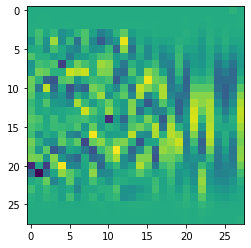

In [5]:
print("\n\n\n##########################################################################")
print("###################### PART 3 - FISHER DIGITS ############################")
print("##########################################################################")  

# Compute the Class Differences and Class Scatter     

Sw = np.zeros((img_dimen, img_dimen))
Sb = np.zeros((img_dimen, img_dimen))
Mu = np.mean(mean_digits, axis=0)
for c in range(10):
    Sum = 0
    for i in range(len(count[c])):
        difff = X[str(c)][i].reshape(img_dimen, img_dimen) - mean_digits[c].reshape(img_dimen, img_dimen)
        Sum += np.dot(np.transpose(difff),difff)
        
    Sw += Sum
    
    # Calculate the between-class scatter matrix
    
    mean_diff = mean_digits[c].reshape(img_dimen, img_dimen) - Mu.reshape(img_dimen, img_dimen)
    Sb += np.dot(np.transpose(mean_diff), mean_diff)

Sb_inverse = np.zeros((img_dimen, img_dimen))
eigen_values = []
eigen_vectors = []

Sb += 0.8*np.eye(img_dimen)     
Sb_inverse = np.linalg.inv(Sb)

classDiff = np.dot(Sw, Sb_inverse)
Lambda, V = np.linalg.eig(classDiff)

eigen_vectors.append(V)
eigen_values.append(Lambda)

nonzero_eig = np.nonzero(Lambda)[0]
reshaped_lambda = Lambda.reshape(1,len(Lambda))

Lambda = Lambda*np.eye(img_dimen)

print("\n\n Displaying Fisher Digits. ")
plt.figure()
image = np.asarray(V)
plt.imshow(image)
plt.show()


